In [3]:
data = pd.read_csv('C:/Users/USER/Downloads/dataset.csv') 
data.head()

,Video URL,Description & Hashtags,Video Count,Username,Transcription
0,https://www.tiktok.com/@piazza.lima/video/7292...,Come todo esto por un solo pago! Barra libre d...,1.4M,piazza.lima,todo lo que está en esta mesa por un solo pago...
1,https://www.tiktok.com/@lifood.pe/video/738935...,🥢Barra libre de makis en @@Ache sushi wok nikk...,19.4K,lifood.pe,"Si te gustan los makis tanto como a mi, tienes..."
2,https://www.tiktok.com/@antojaddos/video/73671...,Sorteamos 4 BARRAS LIBRES DE COMIDA ILIMITADA ...,700.8K,antojaddos,Esta es la barra libre más completa del Perú y...
3,https://www.tiktok.com/@ramiroarribasplata/vid...,BARRA LIBRE DE MAKIS Y ALITAS A S/29.90 💸😱 A u...,824.1K,ramiroarribasplata,La barra libre de makis y alitas a solo $29.90...
4,https://www.tiktok.com/@charapawings/video/738...,¡Ya lo sabes ñañito!🤤🤩#pucallpaperú🌴🦜🐍🐢🦥#alita...,28.9K,charapawings,¿Barra libre de alitas?\n ¡Claro que no!\n Est...


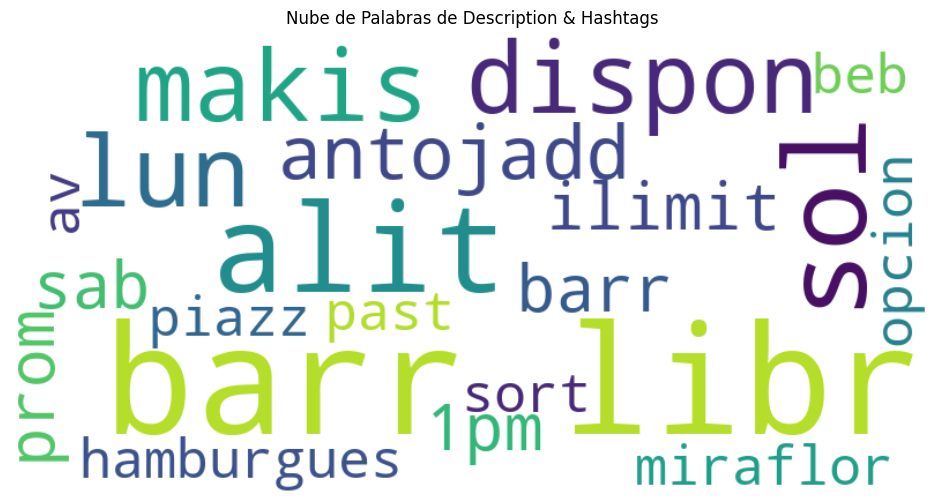

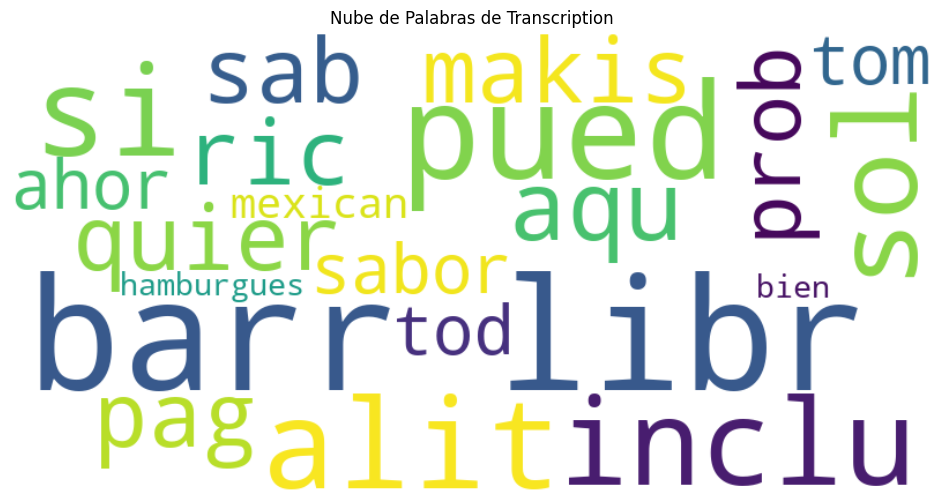

barr        16
libr        14
alit         8
sol          7
com          5
makis        5
dispon       5
lun          5
antojadd     4
sab          3
Name: count, dtype: int64
barr     20
libr     19
pued     14
alit     12
si       12
inclu    11
sol      10
aqu       7
ric       6
sab       6
Name: count, dtype: int64


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Clase personalizada para procesar "Video Count"
class ProcessVideoCount(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['Video Count'] = pd.to_numeric(
            X['Video Count']
            .str.replace(r'K$', 'e3', regex=True)
            .str.replace(r'M$', 'e6', regex=True),
            errors='coerce'
        ).fillna(0).astype(int)
        return X

# Clase personalizada para extraer hashtags y contar
class ProcessHashtags(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['hashtags'] = X['Description & Hashtags'].apply(lambda x: ' '.join(re.findall(r'#\w+', x)))
        X['hashtag_count'] = X['hashtags'].apply(lambda x: len(x.split()) if x else 0)
        return X

# Clase personalizada para preparación de datos
class PrepareData(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['Description & Hashtags'] = X['Description & Hashtags'].str.replace(r'[^\w\s]', '', regex=True).str.lower().str.strip()
        X['Transcription'] = X['Transcription'].str.replace(r'[^\w\s]', '', regex=True).str.lower().str.strip()
        return X

# Clase personalizada para eliminar stopwords
class RemoveStopwords(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('spanish'))
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for column in ['Description & Hashtags', 'Transcription']:
            X[column] = X[column].apply(lambda text: ' '.join([word for word in text.split() if word not in self.stop_words]))
        return X

# Clase personalizada para normalización (Stemming)
class NormalizeText(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stemmer = SnowballStemmer('spanish')
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for column in ['Description & Hashtags', 'Transcription']:
            X[column] = X[column].apply(lambda text: ' '.join([self.stemmer.stem(word) for word in text.split()]))
        return X

# Clase personalizada para el análisis de ngrams
class AnalyzeNgrams(BaseEstimator, TransformerMixin):
    def __init__(self, n=2):
        self.n = n
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def get_ngrams(text, n):
            tokens = text.split()
            ngrams = zip(*[tokens[i:] for i in range(n)])
            return [' '.join(ngram) for ngram in ngrams]
        
        for column in ['Description & Hashtags', 'Transcription']:
            X[f'{column}_bigrams'] = X[column].apply(lambda text: get_ngrams(text, 2))
            X[f'{column}_trigrams'] = X[column].apply(lambda text: get_ngrams(text, 3))
        return X

# Función para crear nubes de palabras
def create_wordcloud(data, column):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=20).generate(' '.join(data[column]))
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Nube de Palabras de {column}")
    plt.show()

# Función para calcular la frecuencia de términos
def term_frequency(data, column):
    term_freq = pd.Series(' '.join(data[column]).split()).value_counts()
    print(term_freq.head(10))
    return term_freq

# Clase personalizada para el análisis de sentimientos
class AnalyzeSentiment(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def sentiment_category(text):
            polarity = TextBlob(text).sentiment.polarity
            if polarity > 0:
                return 'Positivo'
            elif polarity < 0:
                return 'Negativo'
            else:
                return 'Neutro'
        
        X[f'Sentiment_{self.column}'] = X[self.column].apply(sentiment_category)
        return X

# Función principal para ejecutar el pipeline
def main_pipeline(file_path):
    # Cargar datos
    data = pd.read_csv(file_path)
    
    # Definir el pipeline con las clases personalizadas
    pipeline = Pipeline(steps=[
        ('process_video_count', ProcessVideoCount()),
        ('process_hashtags', ProcessHashtags()),
        ('prepare_data', PrepareData()),
        ('remove_stopwords', RemoveStopwords()),
        ('normalize_text', NormalizeText()),
        ('analyze_ngrams', AnalyzeNgrams()),
    ])
    
    # Aplicar el pipeline
    processed_data = pipeline.fit_transform(data)
    
    # Crear nubes de palabras y calcular frecuencia de términos
    create_wordcloud(processed_data, 'Description & Hashtags')
    create_wordcloud(processed_data, 'Transcription')
    
    # Calcular la frecuencia de términos
    term_frequency(processed_data, 'Description & Hashtags')
    term_frequency(processed_data, 'Transcription')
    
    # Análisis de sentimientos
    sentiment_pipeline = Pipeline(steps=[
        ('analyze_sentiment_description', AnalyzeSentiment('Description & Hashtags')),
        ('analyze_sentiment_transcription', AnalyzeSentiment('Transcription')),
    ])
    
    processed_data = sentiment_pipeline.fit_transform(processed_data)
    
    return processed_data

# Ejecutar el pipeline con el archivo de datos
if __name__ == "__main__":
    file_path = 'C:/Users/USER/Downloads/dataset.csv'
    processed_data = main_pipeline(file_path)

In [7]:
processed_data.head()

,Video URL,Description & Hashtags,Video Count,Username,Transcription,hashtags,hashtag_count,Description & Hashtags_bigrams,Description & Hashtags_trigrams,Transcription_bigrams,Transcription_trigrams,Sentiment_Description & Hashtags,Sentiment_Transcription
0,https://www.tiktok.com/@piazza.lima/video/7292...,com sol pag barr libr hamburgues piazz alit pa...,1400000,piazza.lima,mes sol pag cuent inclu mar opcion vas preocup...,#barralibre #miraflores #miraflores_lima_peru ...,4,"[com sol, sol pag, pag barr, barr libr, libr h...","[com sol pag, sol pag barr, pag barr libr, bar...","[mes sol, sol pag, pag cuent, cuent inclu, inc...","[mes sol pag, sol pag cuent, pag cuent inclu, ...",Negativo,Neutro
1,https://www.tiktok.com/@lifood.pe/video/738935...,barr libr makis ache sushi wok nikkei s69 lun ...,19400,lifood.pe,si gust makis añad barr libr list dijeron h me...,#makis #barralibre #foodblogger #foodieperu,4,"[barr libr, libr makis, makis ache, ache sushi...","[barr libr makis, libr makis ache, makis ache ...","[si gust, gust makis, makis añad, añad barr, b...","[si gust makis, gust makis añad, makis añad ba...",Neutro,Positivo
2,https://www.tiktok.com/@antojaddos/video/73671...,sort 4 barr libr com ilimit antojadd tra dat b...,700800,antojaddos,barr libr complet peru ahor inclu past antoj v...,#antojaddos #barralibre #foodies #buffet #ally...,9,"[sort 4, 4 barr, barr libr, libr com, com ilim...","[sort 4 barr, 4 barr libr, barr libr com, libr...","[barr libr, libr complet, complet peru, peru a...","[barr libr complet, libr complet peru, complet...",Negativo,Positivo
3,https://www.tiktok.com/@ramiroarribasplata/vid...,barr libr makis alit s2990 unas cuadr centr li...,824100,ramiroarribasplata,barr libr makis alit sol 2990 pas dat unas cua...,#barralibre #barralibredealitas #centrodelima ...,9,"[barr libr, libr makis, makis alit, alit s2990...","[barr libr makis, libr makis alit, makis alit ...","[barr libr, libr makis, makis alit, alit sol, ...","[barr libr makis, libr makis alit, makis alit ...",Positivo,Neutro
4,https://www.tiktok.com/@charapawings/video/738...,sab ñañitopucallpaperualitashappyhourfastfoodb...,28900,charapawings,barr libr alit clar vez charaj wins tra barr l...,#pucallpaperú #alitas #happyhour #fastfood #ba...,7,[sab ñañitopucallpaperualitashappyhourfastfood...,[],"[barr libr, libr alit, alit clar, clar vez, ve...","[barr libr alit, libr alit clar, alit clar vez...",Neutro,Positivo


In [21]:
df4 = pd.read_csv('C:/Users/USER/Downloads/cupcakeslovers_publicaciones.csv') 
df4.head()

,id,text,isAd,isMuted,webVideoUrl,diggCount,shareCount,playCount,collectCount,commentCount,isSlideshow,isPinned,isSponsored,input,year,month,day,hour,minute,second
0,7237197115972128026,𝔹𝕖𝕒𝕦𝕥𝕚𝕗𝕦𝕝 𝔹𝕝𝕦𝕖💙 What are your thoughts? 💭 #bea...,False,False,https://www.tiktok.com/@kerrysbouqcakes/video/...,173800,7256,3000000,15700,313,False,False,False,cupcakeslovers,2023,5,25,14,1,9
1,7312228214103903520,𝕎𝕙𝕒𝕥'𝕤 𝕪𝕠𝕦𝕣 𝕗𝕒𝕧𝕠𝕦𝕣𝕚𝕥𝕖 𝕥𝕙𝕚𝕟𝕘 𝕒𝕓𝕠𝕦𝕥 ℂ𝕙𝕣𝕚𝕤𝕥𝕞𝕒𝕤? 🎄...,False,False,https://www.tiktok.com/@kerrysbouqcakes/video/...,17600,2263,486900,2296,863,False,False,False,cupcakeslovers,2023,12,13,18,40,11
2,7033841087869504774,#cupxakes #proceso #cremaverde 💚,False,False,https://www.tiktok.com/@cupcakesloversv/video/...,10,0,173,0,0,False,False,False,cupcakeslovers,2021,11,23,13,55,49
3,7425804975353171246,It's my bday... 🎉🎉🎉@CEO of Konfidinz thanks fo...,False,False,https://www.tiktok.com/@brebre0029/video/74258...,7,1,92,0,3,False,False,False,cupcakeslovers,2024,10,14,20,15,57
4,6853215951266090245,#pastelespersonalizados #parati #cupcakeslover 💖,False,False,https://www.tiktok.com/@cupcakesloversv/video/...,257,2,2137,1,0,False,False,False,cupcakeslovers,2020,7,24,19,58,4


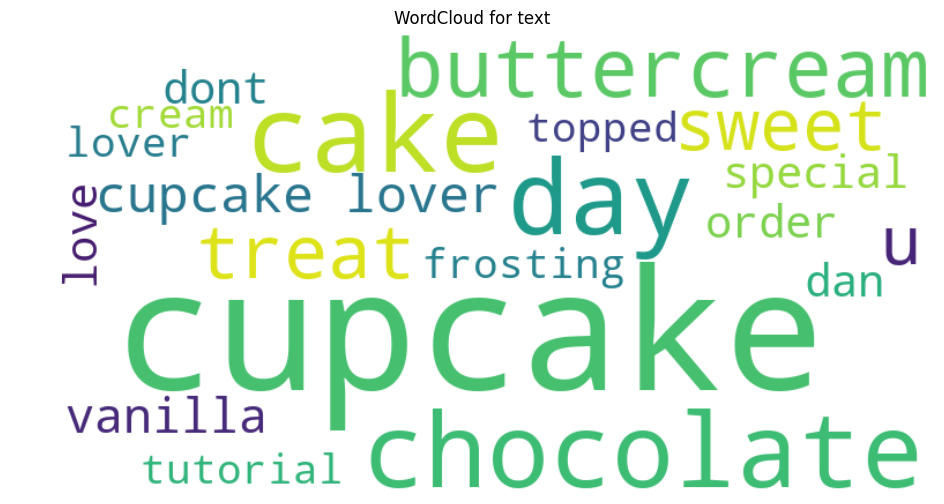

Top 10 Term Frequency:
cupcake        58
chocolate      17
cake           14
day            13
lover          13
buttercream    12
love           10
1              10
treat          10
sweet           9
Name: count, dtype: int64


In [4]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import unicodedata

# 1. Preparación de datos
class PrepareData(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Convertir valores de 'text' a string y manejar NaN
        X['text'] = X['text'].astype(str)

        # Normalizar texto estilizado y convertir a minúsculas
        X['text'] = X['text'].apply(self.normalize_styled_text)

        # Extraer hashtags
        X['hashtags'] = X['text'].apply(lambda x: ' '.join(re.findall(r'#\w+', x)))
        
        # Contar hashtags
        X['hashtag_count'] = X['hashtags'].apply(lambda x: len(x.split()) if x else 0)
        
        # Borrar los hashtags de la columna 'text'
        X['text'] = X['text'].str.replace(r'#\w+', '', regex=True).str.strip()

        # Eliminar caracteres no alfabéticos
        X['text'] = X['text'].str.replace(r'[^\w\s]', '', regex=True).str.strip()
        
        return X
    
    def normalize_styled_text(self, text):
        # Normaliza el texto a la forma de compresión
        normalized = unicodedata.normalize('NFKD', text)
        # Convierte a minúsculas
        return normalized.lower()

# 2. Eliminación de Stop Words
class RemoveStopwords(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Cargar stop words para inglés y español
        self.stop_words = set(stopwords.words('english')).union(set(stopwords.words('spanish')))
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['text'] = X['text'].apply(lambda text: ' '.join([word for word in text.split() if word not in self.stop_words]))
        return X

# 3. Normalización (Lemmatization)
class NormalizeTextLemmatization(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = SnowballStemmer('spanish')

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def lemmatize_text(text):
            words = text.split()
            return ' '.join([self.stemmer.stem(word) if self.detect_language(word) == 'es' else self.lemmatizer.lemmatize(word) for word in words])
        
        X['text'] = X['text'].apply(lemmatize_text)
        return X
    
    def detect_language(self, word):
        # Simple heuristic for detecting language
        if re.search(r'[ñáéíóú]', word):
            return 'es'
        else:
            return 'en'

# 4. Análisis de Ngrams
class AnalyzeNgrams(BaseEstimator, TransformerMixin):
    def __init__(self, n=2):
        self.n = n
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def get_ngrams(text, n):
            tokens = text.split()
            ngrams = zip(*[tokens[i:] for i in range(n)])
            return [' '.join(ngram) for ngram in ngrams]
        
        X[f'bigrams'] = X['text'].apply(lambda text: get_ngrams(text, 2))
        X[f'trigrams'] = X['text'].apply(lambda text: get_ngrams(text, 3))
        return X

# 5. Creación de Nubes de Palabras
def create_wordcloud(data, column):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=20).generate(' '.join(data[column]))
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for {column}")
    plt.show()

# 6. Cálculo de Frecuencia de Términos
def term_frequency(data, column):
    term_freq = pd.Series(' '.join(data[column]).split()).value_counts()
    print("Top 10 Term Frequency:")
    print(term_freq.head(10))
    return term_freq

# 7. Análisis de Sentimientos
class AnalyzeSentiment(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def sentiment_category(text):
            polarity = TextBlob(text).sentiment.polarity
            if polarity > 0:
                return 'Positive'
            elif polarity < 0:
                return 'Negative'
            else:
                return 'Neutral'
        
        X[f'Sentiment_{self.column}'] = X[self.column].apply(sentiment_category)
        return X

# Pipeline principal
def main_pipeline(file_path):
    # Cargar datos desde el archivo proporcionado
    data = pd.read_csv(file_path)
    
    # Definir el pipeline
    pipeline_steps = [
        ('prepare_data', PrepareData()), 
        ('remove_stopwords', RemoveStopwords())
    ]
    
    # 2. Usamos lemmatization
    pipeline_steps.append(('normalize_text', NormalizeTextLemmatization()))
    
    # Pipeline
    pipeline = Pipeline(steps=pipeline_steps)
    
    # Aplicar el pipeline
    processed_data = pipeline.fit_transform(data)

    # 4. Análisis de Ngrams
    ngram_analyzer = AnalyzeNgrams()
    processed_data = ngram_analyzer.fit_transform(processed_data)

    # 5. Creación de Nubes de Palabras
    create_wordcloud(processed_data, 'text')
    
    # 6. Calcular la frecuencia de términos
    term_frequency(processed_data, 'text')
    
    # 7. Análisis de Sentimientos
    sentiment_pipeline = Pipeline(steps=[
        ('analyze_sentiment', AnalyzeSentiment('text'))
    ])
    processed_data = sentiment_pipeline.fit_transform(processed_data)
    return processed_data

# Llamada al pipeline
if __name__ == "__main__":
    file_path = 'C:/Users/USER/Downloads/cupcakeslovers_publicaciones.csv'
    processed_data = main_pipeline(file_path)

In [3]:
processed_data.head()

,id,text,isAd,isMuted,webVideoUrl,diggCount,shareCount,playCount,collectCount,commentCount,...,month,day,hour,minute,second,hashtags,hashtag_count,bigrams,trigrams,Sentiment_text
0,7237197115972128026,beautiful blue thought,False,False,https://www.tiktok.com/@kerrysbouqcakes/video/...,173800,7256,3000000,15700,313,...,5,25,14,1,9,#beautifulblue #blue #buttercream #buttercream...,17,"[beautiful blue, blue thought]",[beautiful blue thought],Positive
1,7312228214103903520,whats favourite thing christmas long go certai...,False,False,https://www.tiktok.com/@kerrysbouqcakes/video/...,17600,2263,486900,2296,863,...,12,13,18,40,11,#buttercream #floralcupcakes #floralpiping #cu...,15,"[whats favourite, favourite thing, thing chris...","[whats favourite thing, favourite thing christ...",Positive
2,7033841087869504774,,False,False,https://www.tiktok.com/@cupcakesloversv/video/...,10,0,173,0,0,...,11,23,13,55,49,#cupxakes #proceso #cremaverde,3,[],[],Neutral
3,7425804975353171246,bday ceo konfidinz thanks cupcakesthey taste good,False,False,https://www.tiktok.com/@brebre0029/video/74258...,7,1,92,0,3,...,10,14,20,15,57,#cupcakelovers #sweets #bdaygirl #bdayqueen #v...,5,"[bday ceo, ceo konfidinz, konfidinz thanks, th...","[bday ceo konfidinz, ceo konfidinz thanks, kon...",Positive
4,6853215951266090245,,False,False,https://www.tiktok.com/@cupcakesloversv/video/...,257,2,2137,1,0,...,7,24,19,58,4,#pastelespersonalizados #parati #cupcakeslover,3,[],[],Neutral


In [ ]:
data2 = pd.read_csv('C:/Users/USER/Downloads/datos_instagram.csv') 
data2.head()